In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from qutip import *
import itertools
from matplotlib.animation import FuncAnimation, PillowWriter
import scipy.integrate as integrate
import scipy.special as special


In [6]:
def imperfect_ECD():
    phase = (1j * theta1 * sigmaz()/2).expm()
    CD = tensor(displace(beta/2), ground * ground.dag()) + tensor(displace(-beta/2), excited * excited.dag())
    D = tensor(displace(dim, l), Iq)
    U = sigmax() * phase * CD * D 
    final = U * state 

# Phi - qubit state dependent rotation of cavity state  

In [7]:
def z(t, T): 
    if t<T/2:
        return -1
    else: 
        return 1

In [8]:
def phi(chi, t, T):
    result = integrate.quad(lambda x:z(x,T) , 0, t, limit = 500)[0]
    return  -chi/2*result

C:\Users\jonat\AppData\Local\Temp\ipykernel_44312\868965777.py:2: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result = integrate.quad(lambda x:z(x,T) , 0, t, limit = 500)[0]


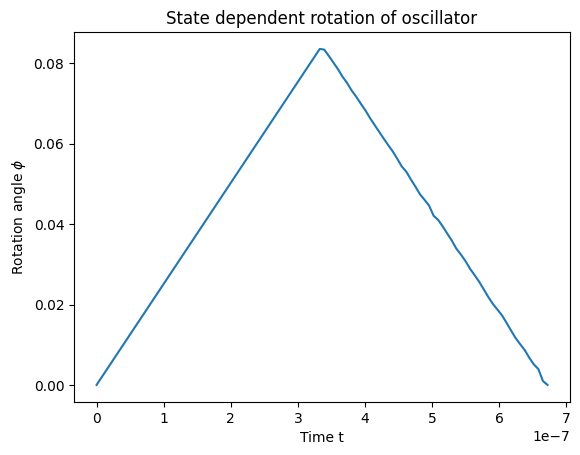

In [9]:
#global parameters of problem 
chi = 2 * np.pi * 80e3 #dispersive coupling frequency shift
tw = 80 * 10**(-9) #wait time
tsin = 4 * 10**(-9)
tsquare = 120 * 10**(-9)
tp = 2*tsin + tsquare #time to play pulses one pulse assumed to be 6 stds long 
T = 2*tw + 4*tp #total gate time 
t = np.linspace(0,T,100)
#plot phi
phi_res = []
for tau in t:
    phi_res.append(phi(chi,tau, T))
plt.title('State dependent rotation of oscillator')
plt.ylabel(r'Rotation angle $\phi$')
plt.xlabel('Time t')
plt.plot(t, phi_res)

# Delta - conditional displacement 

In [10]:
def gaussian(amp, b, std, t): 
    return amp * np.exp(-((t-b)**2)/(2*std**2))
def square(amp, tsin, tsquare, tstart, t):
    if tstart <= t < tstart + tsin: 
        return amp * np.sin(-2*np.pi/(4*tsin)*(tstart -t))
    elif tstart + tsin < t < tstart + tsin + tsquare:
        return amp 
    elif tstart + tsin + tsquare < t <= tstart + 2*tsin + tsquare: 
        return amp * np.cos(-2*np.pi/(4*tsin)*(tstart + tsin + tsquare -t))
    else: return 0
    
def epsilon(amp, std, tw, chi, t):
    tp = 6 * 4 * std #time to play pulses one pulse assumed to be 6 stds long 
    T = 2*tw + tp #total gate time 
    b1 = 3*std #first pulse peak position 
    b2 = b1 + tw + 6*std  #2*std*np.sqrt(2*np.log(20)) # second peak position
    b3 = b2 + 6*std #2*std*np.sqrt(2*np.log(20)) #third peak position 
    b4 = T-3*std #2*std*np.sqrt(2*np.log(20)) #fourth peak position
    r1 = 1
    r2 = np.cos(chi * tw/2)
    r3 = np.cos(chi * tw/2)
    r4 = np.cos(chi * tw)
    return gaussian(r1 * amp, b1, std, t) - gaussian(r2 * amp, b2, std, t) - gaussian(r3 * amp, b3, std, t) + gaussian(r4 * amp, b4, std, t) 
def epsilonsquare(amp, tw, tsin, tsquare, t): 
    tp = (2*tsin + tsquare) 
    T = 2 * tw + 4* tp 
    start1 = 0 
    start2 = tp + tw 
    start3 = 2*tp + tw
    start4 = 3*tp + 2*tw
    r1 = 1
    r2 = np.cos(chi * tw/2)
    r3 = np.cos(chi * tw/2)
    r4 = np.cos(chi * tw)
    return -square( amp, tsin, tsquare, start2, t) - square(amp, tsin, tsquare, start3, t) + square( amp, tsin, tsquare, start4, t)+square(amp, tsin, tsquare, start1, t)

In [11]:
def delta(amp, std, tw, chi, t):
    tp = 6 * 4 * std #time to play pulses one pulse assumed to be 6 stds long 
    T = 2*tw + tp #total gate time 
    result = integrate.quad(lambda x:epsilon(amp, std, tw,chi, x) * np.sin(phi(chi, x, T)-phi(chi, t, T)) , 0, t, limit = 500)[0]
    return - result
def deltasq(amp, tsin, tsquare, tw, chi, t):
    tp = (2*tsin + tsquare) 
    T = 2 * tw + 4* tp 
    result = integrate.quad(lambda x:epsilonsquare(amp, tw, tsin, tsquare, x) * np.sin(phi(chi, x, T)-phi(chi, t, T)) , 0, t, limit = 500)[0] 
    return - result

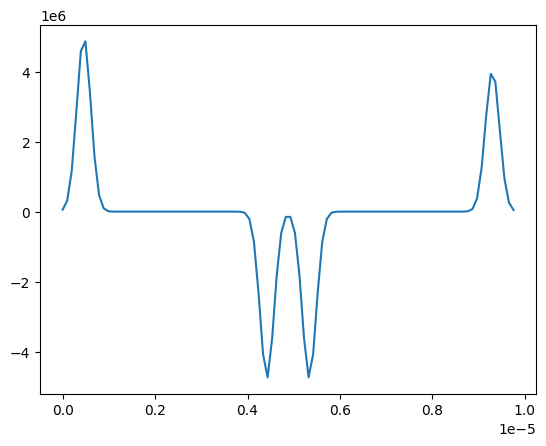

In [12]:
chi = 2 * np.pi * 32.8 * 10**3 #dispersive coupling frequency shift
tw = 2*np.pi/chi * 0.1 #wait time
std = 0.05 * tw #5% of wait time
tp = 6 * 4 * std #time to play pulses one pulse assumed to be 6 stds long 
amp = 5 * 10**6
T = 2*tw + tp #total gate time 
t = np.linspace(0,T,100)
plt.plot(t, epsilon(amp, std, tw, chi, t))

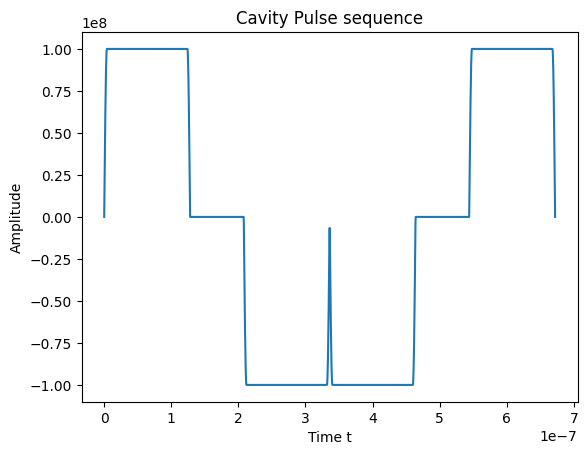

In [13]:
chi = 2 * np.pi * 90 * 10**3 #dispersive coupling frequency shift
tw = 80 * 10**(-9) #wait time
tsin = 4 * 10**(-9)
tsquare = 120 * 10**(-9)
tp = 2*tsin + tsquare #time to play pulses one pulse assumed to be 6 stds long 
T = 2*tw + 4*tp #total gate time 
t = np.linspace(0, T,2000)
amp = 10**8
plt.title('Cavity Pulse sequence')
pulse = []
for i in t: 
    pulse.append(epsilonsquare(amp, tw, tsin, tsquare, i))
plt.xlabel('Time t')
plt.ylabel('Amplitude')
plt.plot(t, pulse)

In [14]:
beta = 2 * delta(amp, std, tw, chi, T)

In [15]:
beta 

4.729486134687495

C:\Users\jonat\AppData\Local\Temp\ipykernel_44312\4017568519.py:4: IntegrationWarning: The maximum number of subdivisions (500) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result = integrate.quad(lambda x:epsilon(amp, std, tw,chi, x) * np.sin(phi(chi, x, T)-phi(chi, t, T)) , 0, t, limit = 500)[0]
C:\Users\jonat\AppData\Local\Temp\ipykernel_44312\4017568519.py:4: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result = integrate.quad(lambda x:epsilon(amp, std, tw,chi, x) * np.sin(phi(chi, x, T)-phi(chi, t, T)) , 0, t, li

Text(0.5, 1.0, 'Blob separation/2')

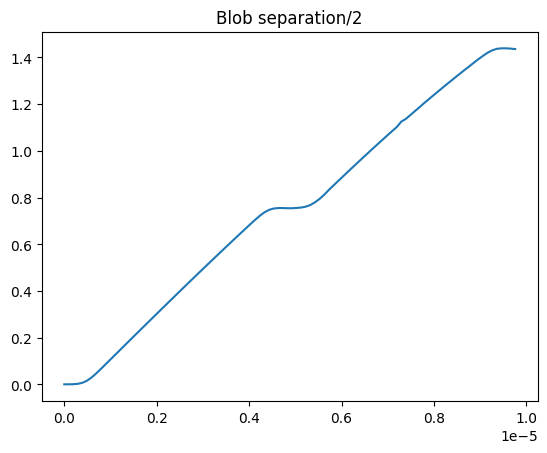

In [16]:
chi = 2 * np.pi * 32.8 * 10**3 #dispersive coupling frequency shift
tw = 2*np.pi/chi * 0.1 #wait time
std = 0.05 * tw #5% of wait time
tp = 6 * 4 * std #time to play pulses one pulse assumed to be 6 stds long 
amp = 5 * 10**6
T = 2*tw + tp #total gate time 
t = np.linspace(0,T,100)
amp = 5*10**6
delta_res = []
for tau in t:
    delta_res.append(delta(amp, std, tw, chi, tau))
plt.plot(t, delta_res)
plt.title('Blob separation/2')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271


/var/folders/8k/sy_cf37x5jz9ym64dsj1glyw0000gn/T/ipykernel_3539/4017568519.py:9: IntegrationWarning: The maximum number of subdivisions (500) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result = integrate.quad(lambda x:epsilonsquare(amp, tw, tsin, tsquare, x) * np.sin(phi(chi, x, T)-phi(chi, t, T)) , 0, t, limit = 500)[0]


272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486


/var/folders/8k/sy_cf37x5jz9ym64dsj1glyw0000gn/T/ipykernel_3539/868965777.py:2: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result = integrate.quad(lambda x:z(x,T) , 0, t, limit = 500)[0]


487
488
489
490
491
492
493
494
495
496
497
498
499


Text(0.5, 1.0, 'Blob separation/2')

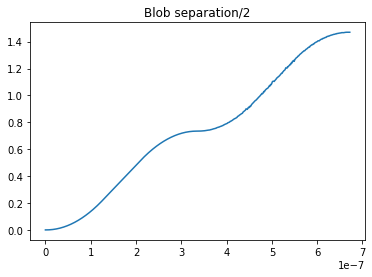

In [437]:
chi = 2 * np.pi * 90 * 10**3 #dispersive coupling frequency shift
tw = 80 * 10**(-9) #wait time
tsin = 4 * 10**(-9)
tsquare = 120 * 10**(-9)
tp = 2*tsin + tsquare #time to play pulses one pulse assumed to be 6 stds long 
T = 2*tw + 4*tp #total gate time 
t = np.linspace(0, T,500)
amp = 10**8
delta_res = []
tick = 0 
for tau in t:
    print(tick)
    delta_res.append(deltasq(amp, tsin, tsquare, tw, chi, tau))
    tick += 1
plt.plot(t, delta_res)
plt.title('Blob separation/2')

Text(0.5, 1.0, 'Blob separation/2')

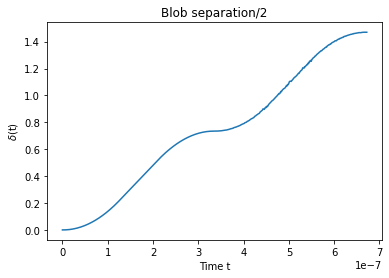

In [445]:
plt.plot(t, delta_res)
plt.ylabel(r'$\delta$(t)')
plt.xlabel(r'Time t')
plt.title('Blob separation/2')

/var/folders/8k/sy_cf37x5jz9ym64dsj1glyw0000gn/T/ipykernel_35159/1341649910.py:2: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result = integrate.quad(lambda x:z(x,T) , 0, t)[0]
/var/folders/8k/sy_cf37x5jz9ym64dsj1glyw0000gn/T/ipykernel_35159/335022382.py:4: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result = integrate.quad(lambda x:epsilon(amp, std, tw, x) * np.sin(phi(chi, x, T)-phi(chi, t, T)) , 0, t)[0]


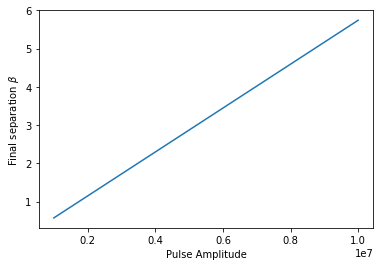

In [176]:
#let us calculate how the final displacement corresponds to the final separation at constant standard deviation
std = 0.05 * tw
amp_range = np.linspace(10**6, 10**7, 20)
betas = []
for amp in amp_range:
    beta = 2 * delta(amp, std, tw, chi, T)
    betas.append(beta)
plt.xlabel('Pulse Amplitude')
plt.ylabel(r'Final separation $\beta$')
plt.plot(amp_range, betas)

/var/folders/8k/sy_cf37x5jz9ym64dsj1glyw0000gn/T/ipykernel_35159/1341649910.py:2: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result = integrate.quad(lambda x:z(x,T) , 0, t)[0]
/var/folders/8k/sy_cf37x5jz9ym64dsj1glyw0000gn/T/ipykernel_35159/335022382.py:4: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result = integrate.quad(lambda x:epsilon(amp, std, tw, x) * np.sin(phi(chi, x, T)-phi(chi, t, T)) , 0, t)[0]


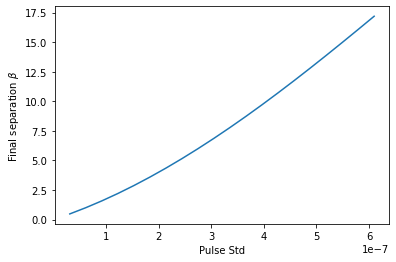

In [182]:
amp = 5*10**6
std_range = np.linspace(0.01 * tw , 0.2 * tw, 20)
betas = []
for std in std_range:
    tp = 6 * 4 * std #time to play pulses one pulse assumed to be 6 stds long 
    T = 2*tw + tp #total gate time 
    beta = 2 * delta(amp, std, tw, chi, T)
    betas.append(beta)
plt.xlabel('Pulse Std')
plt.ylabel(r'Final separation $\beta$')
plt.plot(std_range, betas)

[2.00000000e-08 2.46153846e-08 2.92307692e-08 3.38461538e-08
 3.84615385e-08 4.30769231e-08 4.76923077e-08 5.23076923e-08
 5.69230769e-08 6.15384615e-08 6.61538462e-08 7.07692308e-08
 7.53846154e-08 8.00000000e-08 8.46153846e-08 8.92307692e-08
 9.38461538e-08 9.84615385e-08 1.03076923e-07 1.07692308e-07
 1.12307692e-07 1.16923077e-07 1.21538462e-07 1.26153846e-07
 1.30769231e-07 1.35384615e-07 1.40000000e-07 1.44615385e-07
 1.49230769e-07 1.53846154e-07 1.58461538e-07 1.63076923e-07
 1.67692308e-07 1.72307692e-07 1.76923077e-07 1.81538462e-07
 1.86153846e-07 1.90769231e-07 1.95384615e-07 2.00000000e-07]
2e-08


/var/folders/8k/sy_cf37x5jz9ym64dsj1glyw0000gn/T/ipykernel_3539/4017568519.py:9: IntegrationWarning: The maximum number of subdivisions (500) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result = integrate.quad(lambda x:epsilonsquare(amp, tw, tsin, tsquare, x) * np.sin(phi(chi, x, T)-phi(chi, t, T)) , 0, t, limit = 500)[0]


2.4615384615384616e-08
2.923076923076923e-08
3.384615384615385e-08
3.846153846153847e-08
4.307692307692308e-08
4.76923076923077e-08
5.230769230769231e-08
5.692307692307693e-08
6.153846153846155e-08
6.615384615384617e-08
7.076923076923078e-08
7.538461538461539e-08


/var/folders/8k/sy_cf37x5jz9ym64dsj1glyw0000gn/T/ipykernel_3539/868965777.py:2: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result = integrate.quad(lambda x:z(x,T) , 0, t, limit = 500)[0]


8e-08
8.461538461538461e-08
8.923076923076925e-08
9.384615384615386e-08
9.846153846153848e-08
1.0307692307692309e-07
1.076923076923077e-07
1.1230769230769231e-07
1.1692307692307695e-07
1.2153846153846156e-07
1.2615384615384617e-07
1.3076923076923079e-07
1.353846153846154e-07
1.4e-07
1.4461538461538462e-07
1.4923076923076923e-07
1.5384615384615387e-07
1.5846153846153848e-07
1.630769230769231e-07
1.676923076923077e-07
1.7230769230769232e-07
1.7692307692307693e-07
1.8153846153846154e-07
1.8615384615384618e-07
1.907692307692308e-07
1.953846153846154e-07
2.0000000000000002e-07


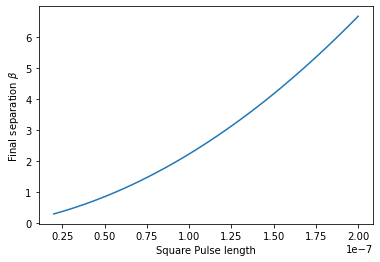

In [458]:
chi = 2 * np.pi * 90 * 10**3 #dispersive coupling frequency shift
tw = 80 * 10**(-9) #wait time
tsin = 4 * 10**(-9)
t = np.linspace(0, T,500)
amp = 10**8
square_range = np.linspace(20*10**(-9), 200*10**(-9), 40)
print(square_range)
betas = []
for sq in square_range:
    print(sq)
    tp = 2*tsin + sq #time to play pulses one pulse assumed to be 6 stds long 
    T = 2*tw + 4*tp #total gate time 
    beta = 2 * deltasq(amp, tsin, sq, tw, chi, T)
    betas.append(beta)
plt.xlabel('Square Pulse length')
plt.ylabel(r'Final separation $\beta$')
plt.plot(square_range, betas)

[2.00000000e-08 2.46153846e-08 2.92307692e-08 3.38461538e-08
 3.84615385e-08 4.30769231e-08 4.76923077e-08 5.23076923e-08
 5.69230769e-08 6.15384615e-08 6.61538462e-08 7.07692308e-08
 7.53846154e-08 8.00000000e-08 8.46153846e-08 8.92307692e-08
 9.38461538e-08 9.84615385e-08 1.03076923e-07 1.07692308e-07
 1.12307692e-07 1.16923077e-07 1.21538462e-07 1.26153846e-07
 1.30769231e-07 1.35384615e-07 1.40000000e-07 1.44615385e-07
 1.49230769e-07 1.53846154e-07 1.58461538e-07 1.63076923e-07
 1.67692308e-07 1.72307692e-07 1.76923077e-07 1.81538462e-07
 1.86153846e-07 1.90769231e-07 1.95384615e-07 2.00000000e-07]
50000000.0


/var/folders/8k/sy_cf37x5jz9ym64dsj1glyw0000gn/T/ipykernel_3539/868965777.py:2: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result = integrate.quad(lambda x:z(x,T) , 0, t, limit = 500)[0]
/var/folders/8k/sy_cf37x5jz9ym64dsj1glyw0000gn/T/ipykernel_3539/4017568519.py:9: IntegrationWarning: The maximum number of subdivisions (500) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result = integrate.quad(lambda x:epsilonsquare(amp, tw, tsin, tsquare, x) * np.sin(phi(chi, x, T)-phi(chi, t, T)) , 0, t, limit = 500)[0]


65517241.37931035
81034482.7586207
96551724.13793103
112068965.51724139
127586206.89655173
143103448.27586207
158620689.6551724
174137931.03448278
189655172.41379312
205172413.79310346
220689655.1724138
236206896.55172414
251724137.93103448
267241379.31034485
282758620.6896552
298275862.06896555
313793103.44827586
329310344.82758623
344827586.20689654
360344827.5862069
375862068.9655172
391379310.3448276
406896551.72413796
422413793.1034483
437931034.48275864
453448275.86206895
468965517.2413793
484482758.6206897
500000000.0


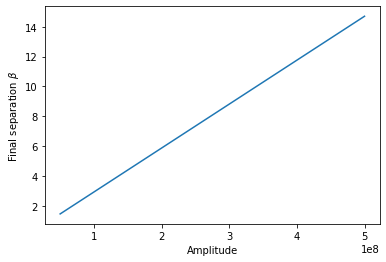

In [461]:
chi = 2 * np.pi * 90 * 10**3 #dispersive coupling frequency shift
tw = 80 * 10**(-9) #wait time
tsin = 4 * 10**(-9)
tsquare = 120 * 10**(-9)
t = np.linspace(0, T,500)
#amp = 10**8
amp_range = np.linspace(5*10**7, 5*10**8, 30)
print(square_range)
betas = []
for amp in amp_range:
    print(amp)
    tp = 2*tsin + tsquare #time to play pulses one pulse assumed to be 6 stds long 
    T = 2*tw + 4*tp #total gate time 
    beta = 2 * deltasq(amp, tsin, tsquare, tw, chi, T)
    betas.append(beta)
plt.xlabel('Amplitude')
plt.ylabel(r'Final separation $\beta$')
plt.plot(amp_range, betas)

# Gamma - Unconditional extra displacement 

In [462]:
def gamma(amp, std, tw, chi, t):
    tp = 6 * 4 * std #time to play pulses one pulse assumed to be 6 stds long 
    T = 2*tw + tp #total gate time 
    result = integrate.quad(lambda x:epsilon(amp, std, tw, x) * np.cos(phi(chi, x, T)-phi(chi, t, T)) , 0, t)[0]
    return -1j* result
def gammasq(amp, tsin, tsquare, tw, chi, t):
    tp = (2*tsin + tsquare) 
    T = 2 * tw + 4* tp 
    result = integrate.quad(lambda x:epsilonsquare(amp, tw, tsin, tsquare, x) * np.cos(phi(chi, x, T)-phi(chi, t, T)) , 0, t, limit = 500)[0]
    return - 1j * result

/var/folders/8k/sy_cf37x5jz9ym64dsj1glyw0000gn/T/ipykernel_3539/3950292141.py:4: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result = integrate.quad(lambda x:epsilon(amp, std, tw, x) * np.cos(phi(chi, x, T)-phi(chi, t, T)) , 0, t)[0]
/var/folders/8k/sy_cf37x5jz9ym64dsj1glyw0000gn/T/ipykernel_3539/3950292141.py:4: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result = integrate.quad(lambda x:epsilon(amp, std, tw, x) * np.cos(phi(chi, x, T)-phi(chi, t, T)) , 0,

Text(0.5, 1.0, 'Displacement')

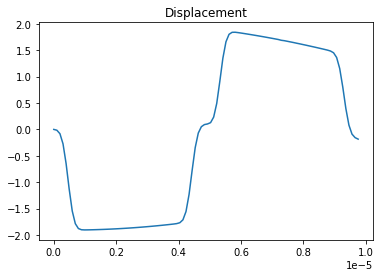

In [11]:
gamma_res = []
chi = 2 * np.pi * 32.8 * 10**3 #dispersive coupling frequency shift
tw = 2*np.pi/chi * 0.1 #wait time
std = 0.05 * tw #5% of wait time
tp = 6 * 4 * std #time to play pulses one pulse assumed to be 6 stds long 
amp = 5*10**6
for tau in t:
    gamma_res.append(gamma(amp, std, tw, chi, tau).imag)
plt.plot(t, gamma_res)
plt.title('Displacement')

-0j
-0.03478738507990659j
-0.12964494377527774j
-0.2586558929672239j
-0.39332517022076896j
-0.5279943873306234j
-0.6626635295130108j
-0.7973325755064197j
-0.9320015075752431j
-1.0666703013275498j
-1.2013389420160627j
-1.3360074084351554j
-1.4706756813774242j
-1.605343740905486j
-1.740011567723953j
-1.8746791421902083j
-2.0093464490624546j
-2.144013456526389j
-2.2786801570807804j
-2.41334652731481j
-2.5480125476068913j
-2.6826781984136696j
-2.8173434603479457j
-2.9520083139014934j
-3.086672739425946j
-3.2213367172387164j
-3.3560002282338544j
-3.4906632526161125j
-3.6253257713857385j
-3.7599877635010097j
-3.8946492108370543j
-4.029310093779962j
-4.163970396413784j
-4.298630087361326j
-4.433289159058988j
-4.5679475881506j
-4.702605349431621j
-4.837262439445084j
-4.971918822985174j
-5.10657448546073j
-5.241229407910865j
-5.375883570256189j
-5.510536953034489j
-5.645189537633503j
-5.779841302752927j
-5.9144922305379035j
-6.049142300460768j
-6.183791493537555j
-6.318439790003076j
-6.45308717

/var/folders/8k/sy_cf37x5jz9ym64dsj1glyw0000gn/T/ipykernel_3539/637630640.py:9: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result = integrate.quad(lambda x:epsilonsquare(amp, tw, tsin, tsquare, x) * np.cos(phi(chi, x, T)-phi(chi, t, T)) , 0, t, limit = 500)[0]


0.7631083106515832j
0.8974190516703309j
1.0319045247615195j
1.1662058781487563j
1.3005462064314246j
1.4351462282967709j
1.5693884396177802j
1.70391429306737j
1.8383283540506967j
1.972464141926245j
2.1069725652897793j
2.2413675459346383j
2.375927212615286j
2.5103981781813864j
2.6447879588800043j
2.778926388097247j
2.913478022672566j
3.047712007679346j
3.1820490130180183j
3.316405695715912j
3.450769221493008j
3.5851674575577834j
3.7197587230051545j
3.853961742481838j
3.9884857741790953j
4.122565924440293j
4.256900810368917j
4.391437666998605j
4.5257635172474915j
4.66031508461915j
4.794620033894696j
4.928932328547831j
5.063452891656825j
5.197757014005378j
5.332180619872956j
5.466661588577446j
5.600757700019517j
5.735270600874415j
5.86951165836315j
6.003925438750134j
6.138404566509885j
6.272658122417106j
6.407225109219927j
6.54136920024233j
6.675834889425887j
6.810283215638609j
6.944723225241273j


/var/folders/8k/sy_cf37x5jz9ym64dsj1glyw0000gn/T/ipykernel_3539/637630640.py:9: IntegrationWarning: The maximum number of subdivisions (500) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result = integrate.quad(lambda x:epsilonsquare(amp, tw, tsin, tsquare, x) * np.cos(phi(chi, x, T)-phi(chi, t, T)) , 0, t, limit = 500)[0]


7.078750127723545j
7.213324386509941j
7.347644153160313j
7.482066194913111j
7.616411408142941j
7.750611389658857j
7.884939948913496j
8.019315934653399j
8.1538694183057j
8.288290178964537j
8.422691976727892j
8.557084699661187j
8.691028549005463j
8.825455938214775j
8.959918345511133j
9.094121579313349j
9.228554769260201j
9.362940323032854j
9.49724006427781j
9.631729653633155j
9.7661694832129j
9.900087627263678j
10.034435384712042j
10.168772675161279j
10.303111358153698j
10.437462683078095j
10.571324816853615j
10.706169103398226j
10.841013129334458j
10.97493064083352j
11.109100361080785j
11.243942082107097j
11.377835138491532j
11.512675496596456j
11.646850561707414j
11.780783305706159j
11.915064876854622j
12.049334495744763j
12.183604970853755j
12.317416943352754j
12.434631313898008j
12.504340982535977j
12.5146776279932j
12.514471299739471j
12.513984178824868j
12.513699555363893j
12.513176738437805j
12.512888702827656j
12.512538742734954j
12.51213710733892j
12.511696275837528j
12.51122865

/var/folders/8k/sy_cf37x5jz9ym64dsj1glyw0000gn/T/ipykernel_3539/868965777.py:2: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result = integrate.quad(lambda x:z(x,T) , 0, t, limit = 500)[0]


1.5418164359048223j
1.4075941063845638j
1.2729391286335439j
1.1379812424040046j
1.0019109192879052j
0.8651829999425533j
0.7305192108337393j
0.5944171657981758j
0.45975109549972054j
0.32508541055460294j
0.19041949633787353j
0.061411218098461694j
-0.03507251336273562j
-0.06986030654773842j


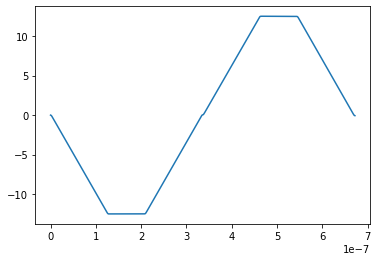

In [471]:
chi = 2 * np.pi * 90 * 10**3 #dispersive coupling frequency shift
tw = 80 * 10**(-9) #wait time
tsin = 4 * 10**(-9)
tsquare = 120 * 10**(-9)
tp = 2*tsin + tsquare #time to play pulses one pulse assumed to be 6 stds long 
T = 2*tw + 4*tp #total gate time 
t = np.linspace(0, T,500)
amp = 10**8
gamma_res = []
tick = 0 
for tau in t:
    a = gammasq(amp, tsin, tsquare, tw, chi, tau)
    print(a)
    gamma_res.append(a.imag)
    tick += 1
plt.plot(t, gamma_res)

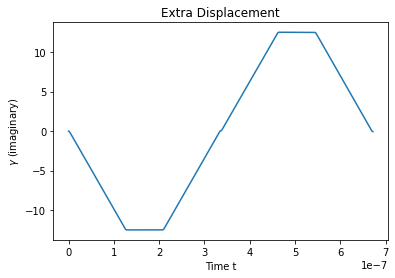

In [476]:
plt.xlabel('Time t')
plt.ylabel(r'$\gamma$ (imaginary)')
plt.title('Extra Displacement')
plt.plot(t, gamma_res)

In [477]:
gammasq(amp, tsin, tsquare, tw, chi, T)

/var/folders/8k/sy_cf37x5jz9ym64dsj1glyw0000gn/T/ipykernel_3539/868965777.py:2: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result = integrate.quad(lambda x:z(x,T) , 0, t, limit = 500)[0]
/var/folders/8k/sy_cf37x5jz9ym64dsj1glyw0000gn/T/ipykernel_3539/637630640.py:9: IntegrationWarning: The maximum number of subdivisions (500) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result = integrate.quad(lambda x:epsilonsquare(amp, tw, tsin, tsquare, x) * np.cos(phi(chi, x, T)-phi(chi, t, T)) , 0, t, limit = 500)[0]


-0.06986030654773842j

In [135]:
chi = 2 * np.pi * 32.8 * 10**3 #dispersive coupling frequency shift
tw = 2*np.pi/chi * 0.1 #wait time
std = 0.05 * tw #5% of wait time
tp = 6 * 4 * std #time to play pulses one pulse assumed to be 6 stds long 
T = 2*tw + tp #total gate time 
amp = 5*10**6
gamma(amp, std, tw, chi, T)

/var/folders/8k/sy_cf37x5jz9ym64dsj1glyw0000gn/T/ipykernel_3539/868965777.py:2: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result = integrate.quad(lambda x:z(x,T) , 0, t, limit = 500)[0]
/var/folders/8k/sy_cf37x5jz9ym64dsj1glyw0000gn/T/ipykernel_3539/3950292141.py:4: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result = integrate.quad(lambda x:epsilon(amp, std, tw, x) * np.cos(phi(chi, x, T)-phi(chi, t, T)) , 0, t)[0]


-0.18416325465828393j

/var/folders/8k/sy_cf37x5jz9ym64dsj1glyw0000gn/T/ipykernel_35159/1341649910.py:2: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result = integrate.quad(lambda x:z(x,T) , 0, t)[0]
/var/folders/8k/sy_cf37x5jz9ym64dsj1glyw0000gn/T/ipykernel_35159/3950292141.py:4: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result = integrate.quad(lambda x:epsilon(amp, std, tw, x) * np.cos(phi(chi, x, T)-phi(chi, t, T)) , 0, t)[0]
/var/folders/8k/sy_cf37x5jz9ym64dsj1glyw0000gn/T/ipykernel_35159/3950292141.py:4: IntegrationWarning: The occurrence of roundoff error is

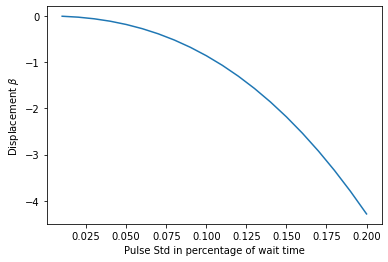

In [211]:
amp = 5*10**6
std_range = np.linspace(0.01 , 0.2 , 20)
betas = []
for std in std_range:
    tp = 6 * 4 * std *tw #time to play pulses one pulse assumed to be 6 stds long 
    T = 2*tw + tp #total gate time 
    beta = gamma(amp, std*tw, tw, chi, T).imag 
    betas.append(beta)
plt.xlabel('Pulse Std in percentage of wait time')
plt.ylabel(r'Displacement $\beta$')
plt.plot(std_range, betas)

[2.00000000e-08 2.62068966e-08 3.24137931e-08 3.86206897e-08
 4.48275862e-08 5.10344828e-08 5.72413793e-08 6.34482759e-08
 6.96551724e-08 7.58620690e-08 8.20689655e-08 8.82758621e-08
 9.44827586e-08 1.00689655e-07 1.06896552e-07 1.13103448e-07
 1.19310345e-07 1.25517241e-07 1.31724138e-07 1.37931034e-07
 1.44137931e-07 1.50344828e-07 1.56551724e-07 1.62758621e-07
 1.68965517e-07 1.75172414e-07 1.81379310e-07 1.87586207e-07
 1.93793103e-07 2.00000000e-07]
2e-08


/var/folders/8k/sy_cf37x5jz9ym64dsj1glyw0000gn/T/ipykernel_3539/637630640.py:9: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result = integrate.quad(lambda x:epsilonsquare(amp, tw, tsin, tsquare, x) * np.cos(phi(chi, x, T)-phi(chi, t, T)) , 0, t, limit = 500)[0]


2.620689655172414e-08
3.241379310344828e-08
3.8620689655172417e-08
4.4827586206896555e-08
5.1034482758620694e-08
5.724137931034483e-08
6.344827586206897e-08
6.96551724137931e-08
7.586206896551724e-08


/var/folders/8k/sy_cf37x5jz9ym64dsj1glyw0000gn/T/ipykernel_3539/868965777.py:2: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result = integrate.quad(lambda x:z(x,T) , 0, t, limit = 500)[0]
/var/folders/8k/sy_cf37x5jz9ym64dsj1glyw0000gn/T/ipykernel_3539/637630640.py:9: IntegrationWarning: The maximum number of subdivisions (500) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result = integrate.quad(lambda x:epsilonsquare(amp, tw, tsin, tsquare, x) * np.cos(phi(chi, x, T)-phi(chi, t, T)) , 0, t, limit = 500)[0]


8.206896551724138e-08
8.827586206896552e-08
9.448275862068966e-08
1.006896551724138e-07
1.0689655172413794e-07
1.1310344827586207e-07
1.1931034482758621e-07
1.2551724137931035e-07
1.317241379310345e-07
1.3793103448275863e-07
1.4413793103448277e-07
1.503448275862069e-07
1.5655172413793105e-07
1.6275862068965518e-07
1.6896551724137932e-07
1.7517241379310346e-07
1.813793103448276e-07
1.8758620689655174e-07
1.9379310344827588e-07
2.0000000000000002e-07


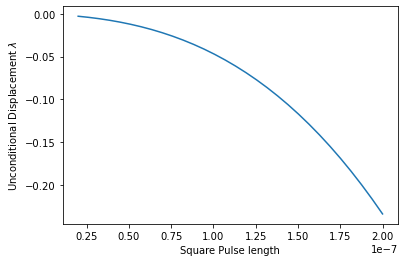

In [478]:
chi = 2 * np.pi * 90 * 10**3 #dispersive coupling frequency shift
tw = 80 * 10**(-9) #wait time
tsin = 4 * 10**(-9)
t = np.linspace(0, T,500)
amp = 10**8
square_range = np.linspace(20*10**(-9), 200*10**(-9), 30)
print(square_range)
betas = []
for sq in square_range:
    print(sq)
    tp = 2*tsin + sq #time to play pulses one pulse assumed to be 6 stds long 
    T = 2*tw + 4*tp #total gate time 
    beta = gammasq(amp, tsin, sq, tw, chi, T)
    betas.append(beta.imag)
plt.xlabel('Square Pulse length')
plt.ylabel(r'Unconditional Displacement $\lambda$')
plt.plot(square_range, betas)

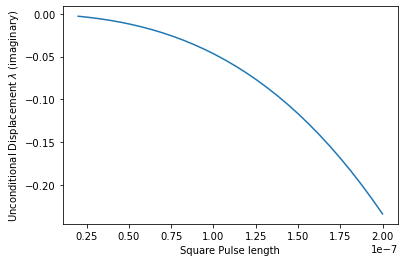

In [479]:
plt.xlabel('Square Pulse length')
plt.ylabel(r'Unconditional Displacement $\lambda$ (imaginary)')
plt.plot(square_range, betas)

/var/folders/8k/sy_cf37x5jz9ym64dsj1glyw0000gn/T/ipykernel_35159/3950292141.py:4: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result = integrate.quad(lambda x:epsilon(amp, std, tw, x) * np.cos(phi(chi, x, T)-phi(chi, t, T)) , 0, t)[0]


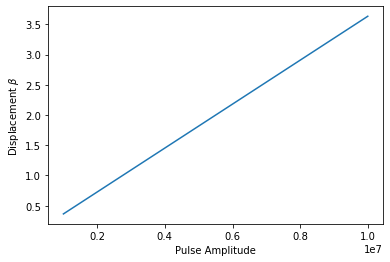

In [212]:
#let us calculate how the final displacement corresponds to the final separation at constant standard deviation
std = 0.05 * tw
amp_range = np.linspace(10**6, 10**7, 20)
betas = []
for amp in amp_range:
    tp = 6 * 4 * std *tw #time to play pulses one pulse assumed to be 6 stds long 
    T = 2*tw + tp #total gate time 
    beta = gamma(amp, std, tw, chi, T).imag
    betas.append(beta)
plt.xlabel('Pulse Amplitude')
plt.ylabel(r'Displacement $\beta$')
plt.plot(amp_range, betas)

[2.00000000e-08 2.62068966e-08 3.24137931e-08 3.86206897e-08
 4.48275862e-08 5.10344828e-08 5.72413793e-08 6.34482759e-08
 6.96551724e-08 7.58620690e-08 8.20689655e-08 8.82758621e-08
 9.44827586e-08 1.00689655e-07 1.06896552e-07 1.13103448e-07
 1.19310345e-07 1.25517241e-07 1.31724138e-07 1.37931034e-07
 1.44137931e-07 1.50344828e-07 1.56551724e-07 1.62758621e-07
 1.68965517e-07 1.75172414e-07 1.81379310e-07 1.87586207e-07
 1.93793103e-07 2.00000000e-07]


/var/folders/8k/sy_cf37x5jz9ym64dsj1glyw0000gn/T/ipykernel_3539/868965777.py:2: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result = integrate.quad(lambda x:z(x,T) , 0, t, limit = 500)[0]
/var/folders/8k/sy_cf37x5jz9ym64dsj1glyw0000gn/T/ipykernel_3539/637630640.py:9: IntegrationWarning: The maximum number of subdivisions (500) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result = integrate.quad(lambda x:epsilonsquare(amp, tw, tsin, tsquare, x) * np.cos(phi(chi, x, T)-phi(chi, t, T)) , 0, t, limit = 500)[0]


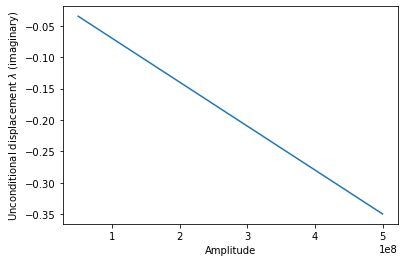

In [480]:
chi = 2 * np.pi * 90 * 10**3 #dispersive coupling frequency shift
tw = 80 * 10**(-9) #wait time
tsin = 4 * 10**(-9)
tsquare = 120 * 10**(-9)
t = np.linspace(0, T,500)
#amp = 10**8
amp_range = np.linspace(5*10**7, 5*10**8, 30)
print(square_range)
betas = []
for amp in amp_range:
    tp = 2*tsin + tsquare #time to play pulses one pulse assumed to be 6 stds long 
    T = 2*tw + 4*tp #total gate time 
    beta = gammasq(amp, tsin, tsquare, tw, chi, T)
    betas.append(beta.imag)
plt.xlabel('Amplitude')
plt.ylabel(r'Unconditional displacement $\lambda$ (imaginary)' )
plt.plot(amp_range, betas)

0


/var/folders/8k/sy_cf37x5jz9ym64dsj1glyw0000gn/T/ipykernel_35159/1341649910.py:2: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result = integrate.quad(lambda x:z(x,T) , 0, t)[0]
/var/folders/8k/sy_cf37x5jz9ym64dsj1glyw0000gn/T/ipykernel_35159/3950292141.py:4: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result = integrate.quad(lambda x:epsilon(amp, std, tw, x) * np.cos(phi(chi, x, T)-phi(chi, t, T)) , 0, t)[0]
/var/folders/8k/sy_cf37x5jz9ym64dsj1glyw0000gn/T/ipykernel_35159/3950292141.py:4: IntegrationWarning: The occurrence of roundoff error is

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


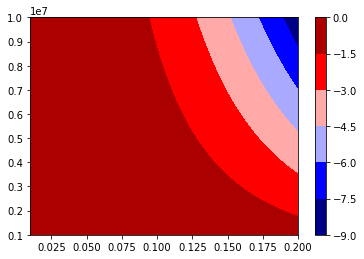

In [194]:
amp_range = np.linspace(10**6, 10**7, 30)
std_range = np.linspace(0.01 , 0.2 , 30)
betas = []
ticker = 0
for amp in amp_range:
    betas.append([])
    print(ticker)
    for std in std_range:
        tp = 6 * 4 * std *tw #time to play pulses one pulse assumed to be 6 stds long 
        T = 2*tw + tp #total gate time 
        beta = gamma(amp, std*tw, tw, chi, T).imag
        betas[ticker].append(beta)
    ticker += 1
    
plt.contourf(std_range, amp_range, betas, cmap='seismic')
plt.colorbar();   


        
        
        

# Theta - Qubit Phase 

In [505]:
def theta(amp, std, tw, chi, t):
    #tp = 6 * 4 * std #time to play pulses one pulse assumed to be 6 stds long 
    #T = 2*tw + tp #total gate time
    print(t)
    
    result = integrate.quad(lambda x: epsilon(amp, std, tw, x)*delta(amp, std, tw, chi, x), 0, t, limit = 500)[0]
    
    return -2 * result 

def theta2(amp, std, tw, chi, t):
    res = 0 
    step = t/1000
    allt = np.linspace(0,t, 1000)
    for i in allt:
        if epsilon(amp, std, tw, i) < 0.05 * amp: 
            continue 
        res += epsilon(amp, std, tw, i)*delta(amp, std, tw, chi, i) * step
    return res 

def thetasq(amp, tsin, tsquare, tw, chi, t):
    tp = (2*tsin + tsquare) 
    T = 2 * tw + 4* tp 
    result = integrate.quad(lambda x:epsilonsquare(amp, tw, tsin, tsquare, x) * deltasq(amp, tsin, tsquare, tw, chi, x) , 0, t, limit = 50)[0]
    return - 2 * result

def thetasq2(amp, tsin, tsquare, tw, chi, t):
    res = 0 
    step = t/500
    allt = np.linspace(0,t, 500)
    for i in allt:
        res += epsilonsquare(amp, tw, tsin, tsquare, i) * deltasq(amp, tsin, tsquare, tw, chi, i) * step
    return res
    

In [200]:
theta_res = []
chi = 2 * np.pi * 32.8 * 10**3 #dispersive coupling frequency shift
tw = 2*np.pi/chi * 0.1 #wait time
std = 0.05 * tw #5% of wait time
tp = 6 * 4 * std #time to play pulses one pulse assumed to be 6 stds long 
amp = 5*10**6
T = 2*tw + tp #total gate time 
t = np.linspace(0,T,50)
for tau in t:
    print(tau)
    theta_res.append(theta(amp, std, tw, chi, tau))
plt.plot(t, theta_res)
plt.title('Qubit Phase')


0.0
0.0
1.991040318566452e-07
1.991040318566452e-07
3.982080637132904e-07
3.982080637132904e-07
5.973120955699356e-07
5.973120955699356e-07
7.964161274265808e-07
7.964161274265808e-07
9.95520159283226e-07
9.95520159283226e-07
1.1946241911398711e-06
1.1946241911398711e-06
1.3937282229965165e-06
1.3937282229965165e-06
1.5928322548531616e-06
1.5928322548531616e-06
1.7919362867098067e-06
1.7919362867098067e-06
1.991040318566452e-06
1.991040318566452e-06
2.1901443504230974e-06
2.1901443504230974e-06
2.3892483822797423e-06
2.3892483822797423e-06
2.5883524141363876e-06
2.5883524141363876e-06
2.787456445993033e-06
2.787456445993033e-06
2.986560477849678e-06
2.986560477849678e-06
3.185664509706323e-06
3.185664509706323e-06
3.3847685415629685e-06
3.3847685415629685e-06
3.5838725734196134e-06
3.5838725734196134e-06
3.7829766052762587e-06
3.7829766052762587e-06
3.982080637132904e-06
3.982080637132904e-06
4.181184668989549e-06
4.181184668989549e-06
4.380288700846195e-06
4.380288700846195e-06
4.5793

KeyboardInterrupt: 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38


/var/folders/8k/sy_cf37x5jz9ym64dsj1glyw0000gn/T/ipykernel_3539/4017568519.py:9: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result = integrate.quad(lambda x:epsilonsquare(amp, tw, tsin, tsquare, x) * np.sin(phi(chi, x, T)-phi(chi, t, T)) , 0, t, limit = 500)[0]


39
40
41
42
43
44
45
46
47
48
49
50
51
52
53


/var/folders/8k/sy_cf37x5jz9ym64dsj1glyw0000gn/T/ipykernel_3539/4017568519.py:9: IntegrationWarning: The maximum number of subdivisions (500) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result = integrate.quad(lambda x:epsilonsquare(amp, tw, tsin, tsquare, x) * np.sin(phi(chi, x, T)-phi(chi, t, T)) , 0, t, limit = 500)[0]


54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96


/var/folders/8k/sy_cf37x5jz9ym64dsj1glyw0000gn/T/ipykernel_3539/868965777.py:2: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result = integrate.quad(lambda x:z(x,T) , 0, t, limit = 500)[0]


97
98
99


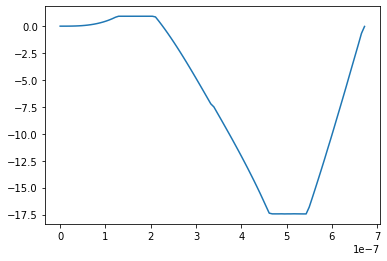

In [506]:
chi = 2 * np.pi * 90 * 10**3 #dispersive coupling frequency shift
tw = 80 * 10**(-9) #wait time
tsin = 4 * 10**(-9)
tsquare = 120 * 10**(-9)
tp = 2*tsin + tsquare 
T = 2*tw + 4*tp #total gate time 
t = np.linspace(0, T,100)
amp = 10**8
theta_res = []
tick = 0 
for tau in t:
    a = thetasq2(amp, tsin, tsquare, tw, chi, tau)
    print(tick)
    theta_res.append(a)
    tick += 1
plt.plot(t, theta_res)

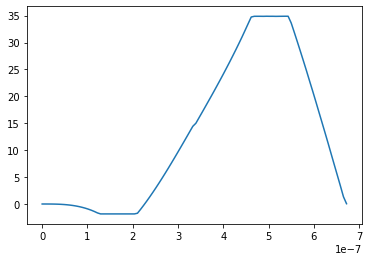

In [507]:
res = []
for i in theta_res:
    res.append(-2*i)
plt.plot(t, res)

[2.0e-08 4.0e-08 6.0e-08 8.0e-08 1.0e-07 1.2e-07 1.4e-07 1.6e-07 1.8e-07
 2.0e-07]
2e-08


/var/folders/8k/sy_cf37x5jz9ym64dsj1glyw0000gn/T/ipykernel_3539/4017568519.py:9: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result = integrate.quad(lambda x:epsilonsquare(amp, tw, tsin, tsquare, x) * np.sin(phi(chi, x, T)-phi(chi, t, T)) , 0, t, limit = 500)[0]
/var/folders/8k/sy_cf37x5jz9ym64dsj1glyw0000gn/T/ipykernel_3539/4017568519.py:9: IntegrationWarning: The maximum number of subdivisions (500) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result = integrate.quad(lambda x:epsilonsquare(amp, tw, tsin, tsquare, x

4e-08
6.000000000000001e-08
8e-08


/var/folders/8k/sy_cf37x5jz9ym64dsj1glyw0000gn/T/ipykernel_3539/868965777.py:2: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result = integrate.quad(lambda x:z(x,T) , 0, t, limit = 500)[0]


1.0000000000000002e-07
1.2000000000000002e-07
1.4e-07
1.6000000000000003e-07
1.8000000000000002e-07
2.0000000000000002e-07


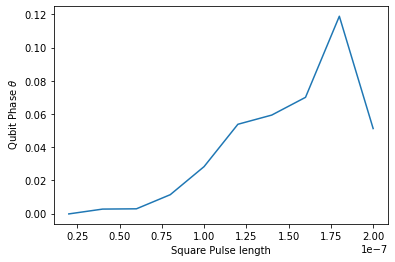

In [510]:
chi = 2 * np.pi * 90 * 10**3 #dispersive coupling frequency shift
tw = 80 * 10**(-9) #wait time
tsin = 4 * 10**(-9)
t = np.linspace(0, T,500)
amp = 10**8
square_range = np.linspace(20*10**(-9), 200*10**(-9), 10)
print(square_range)
betas = []
for sq in square_range:
    print(sq)
    tp = 2*tsin + sq #time to play pulses one pulse assumed to be 6 stds long 
    T = 2*tw + 4*tp #total gate time 
    beta = -2*thetasq2(amp, tsin, sq, tw, chi, T)
    betas.append(beta)
plt.xlabel('Square Pulse length')
plt.ylabel(r' Qubit Phase $\theta$')
plt.plot(square_range, betas)

In [511]:
print(betas)

[-0.0001683978062459241, 0.0027385317443100353, 0.002906438924519215, 0.011407375704172733, 0.028307941584585532, 0.0538121711833619, 0.05934094036417666, 0.07003734939828883, 0.11886583534300166, 0.05123776269062128]


In [513]:
theta = []
chi = 2 * np.pi * 90 * 10**3 #dispersive coupling frequency shift
tw = 80 * 10**(-9) #wait time
tsin = 4 * 10**(-9)
tsquare = 120 * 10**(-9)
tp = 2*tsin + tsquare 
T = 2*tw + 4*tp #total gate time 
t = np.linspace(0, T,100)
b = (gammasq(amp, tsin, tsquare, tw, chi, T)* deltasq(amp, tsin, tsquare, tw, chi, T)).imag
amp = 10**8
for i in betas:
    print(i)
    theta.append(i + (gammasq(amp, tsin, tsquare, tw, chi, T)* deltasq(amp, tsin, tsquare, tw, chi, T)).imag)

-0.0001683978062459241


/var/folders/8k/sy_cf37x5jz9ym64dsj1glyw0000gn/T/ipykernel_3539/4017568519.py:9: IntegrationWarning: The maximum number of subdivisions (500) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result = integrate.quad(lambda x:epsilonsquare(amp, tw, tsin, tsquare, x) * np.sin(phi(chi, x, T)-phi(chi, t, T)) , 0, t, limit = 500)[0]
/var/folders/8k/sy_cf37x5jz9ym64dsj1glyw0000gn/T/ipykernel_3539/868965777.py:2: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result = integrate.quad(lambda x:z(x,T) , 0, t, limit = 500)[0]


KeyboardInterrupt: 

In [518]:
theta = 0.0538121711833619 + 2*(-0.0699*1j * deltasq(amp, tsin, tsquare, tw, chi, T).imag)
theta

/var/folders/8k/sy_cf37x5jz9ym64dsj1glyw0000gn/T/ipykernel_3539/868965777.py:2: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result = integrate.quad(lambda x:z(x,T) , 0, t, limit = 500)[0]
/var/folders/8k/sy_cf37x5jz9ym64dsj1glyw0000gn/T/ipykernel_3539/4017568519.py:9: IntegrationWarning: The maximum number of subdivisions (500) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result = integrate.quad(lambda x:epsilonsquare(amp, tw, tsin, tsquare, x) * np.sin(phi(chi, x, T)-phi(chi, t, T)) , 0, t, limit = 500)[0]


(0.0538121711833619+0j)

In [ ]:
plt.xlabel('Square Pulse length')
plt.ylabel(r' Qubit Phase $\theta$')
plt.plot(square_range, theta)

In [122]:
tp = 6 * 4 * std #time to play pulses one pulse assumed to be 6 stds long 
T = 2*tw + tp #total gate time 
theta2(amp, std, tw, chi, T)#2*(gamma(amp, std, tw, chi, T) * delta(amp, std, tw, chi, T)).imag

/var/folders/8k/sy_cf37x5jz9ym64dsj1glyw0000gn/T/ipykernel_3539/1482311254.py:4: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result = integrate.quad(lambda x:epsilon(amp, std, tw, x) * np.sin(phi(chi, x, T)-phi(chi, t, T)) , 0, t, limit = 500)[0]
/var/folders/8k/sy_cf37x5jz9ym64dsj1glyw0000gn/T/ipykernel_3539/868965777.py:2: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result = integrate.quad(lambda x:z(x,T) , 0, t, limit = 500)[0]


2.198892031552472

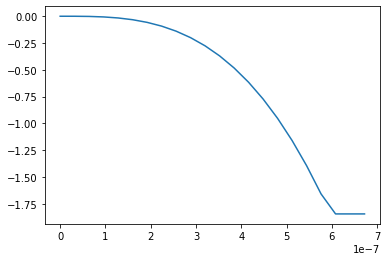

In [503]:
t = np.linspace(0, T,22)
plt.plot(t, theta_res)

# Gate Simulation of ECD

In [519]:
dim = 60
ground = Qobj([[1],[0]])
excited = Qobj([[0],[1]])
Ir = qeye(dim)
Iq = qeye(2)
def imperfect_ECD(state, lam, theta1, beta, dim):
    phase = tensor(Ir, (1j * theta1 * sigmaz()/2).expm())
    CD = tensor(displace(dim, beta/2), ground * ground.dag()) + tensor(displace(dim, -beta/2), excited * excited.dag())
    D = tensor(displace(dim, lam), Iq)
    U = tensor(Ir,sigmax()) * phase * CD * D 
    final = U * state 
    return final 

In [202]:


chi = 2 * np.pi * 15 * 10**3 #dispersive coupling frequency shift

tw = 2*np.pi/chi * 0.1 #wait time
std = 0.05 * tw #5% of wait time
tp = 6 * 4 * std #time to play pulses one pulse assumed to be 6 stds long 
T = 2*tw + tp #total gate time 
amp = 5*10**6
lam = gamma(amp, std, tw, chi, T)
beta = 2* delta(amp, std, tw, chi, T)
theta1 = theta2(amp, std, tw, chi, T) + 2*(lam *beta/2).imag

/var/folders/8k/sy_cf37x5jz9ym64dsj1glyw0000gn/T/ipykernel_3539/3950292141.py:4: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result = integrate.quad(lambda x:epsilon(amp, std, tw, x) * np.cos(phi(chi, x, T)-phi(chi, t, T)) , 0, t)[0]
/var/folders/8k/sy_cf37x5jz9ym64dsj1glyw0000gn/T/ipykernel_3539/1482311254.py:4: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result = integrate.quad(lambda x:epsilon(amp, std, tw, x) * np.sin(phi(chi, x, T)-phi(chi, t, T)) , 0,

In [203]:
print(lam)
print(theta1)
print(beta)
print(chi)

-0.4026962033151736j
7.985754842323366
6.278380650164329
94247.77960769378


In [530]:
beta = 2*deltasq(amp, tsin, tsquare, tw, chi, T)
state = tensor(coherent(dim, 0), 1/np.sqrt(2)*(ground + excited))

/var/folders/8k/sy_cf37x5jz9ym64dsj1glyw0000gn/T/ipykernel_3539/868965777.py:2: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result = integrate.quad(lambda x:z(x,T) , 0, t, limit = 500)[0]
/var/folders/8k/sy_cf37x5jz9ym64dsj1glyw0000gn/T/ipykernel_3539/4017568519.py:9: IntegrationWarning: The maximum number of subdivisions (500) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result = integrate.quad(lambda x:epsilonsquare(amp, tw, tsin, tsquare, x) * np.sin(phi(chi, x, T)-phi(chi, t, T)) , 0, t, limit = 500)[0]


In [531]:
#first ideal gate 
final = imperfect_ECD(state, 0, 0, beta, dim)

In [532]:
#pi/2 pulse 
PI = tensor(Ir,Qobj([[1,1],[1,-1]]))
final2 = PI * final 
final3 = tensor(Ir, ground.dag()) * final2


In [541]:
Z = []
x = np.linspace(-8,8,30) #re part beta A 
y = np.linspace(-8,8,30) #im part beta A
ticker = 0
cstate = final3

for betaB in y:
    Z.append([])
    for betaA in x: 
        result = (cstate * cstate.dag()* displace(dim, betaA+ 1j*betaB)).tr()
        #defintion of characteristic function
        Z[ticker].append(result.real)
    ticker += 1

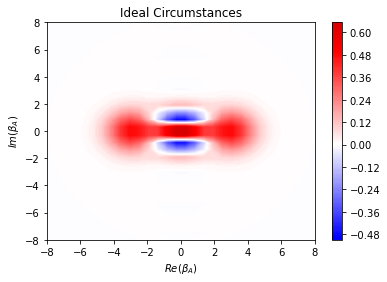

In [543]:
plt.contourf(x, y, Z, 200, cmap = 'seismic', norm = plt.Normalize(vmin = -1, vmax = 1))
plt.colorbar();      
plt.ylabel(r'$Im(\beta_A)$')
plt.xlabel(r'$Re(\beta_A)$')
plt.title('Ideal Circumstances')
plt.show()

In [544]:
#now realistic gate 
lam = -0.0699 * 1j
theta = 0.0538121711833619
final = imperfect_ECD(state, lam,theta, beta, dim)
#pi/2 pulse 
PI = tensor(Ir,Qobj([[1,1],[1,-1]]))
final2 = PI * final 
#final25 = tensor(displace(dim,-lam), Iq) * final2
final3 = tensor(Ir, ground.dag()) * final2


In [545]:
Z = []
x = np.linspace(-8,8,30) #re part beta A 
y = np.linspace(-8,8,30) #im part beta A
ticker = 0
cstate = final3

for betaB in y:
    Z.append([])
    for betaA in x: 
        result = (cstate * cstate.dag()* displace(dim, betaA+ 1j*betaB)).tr()
        #defintion of characteristic function
        Z[ticker].append(result.real)
    ticker += 1

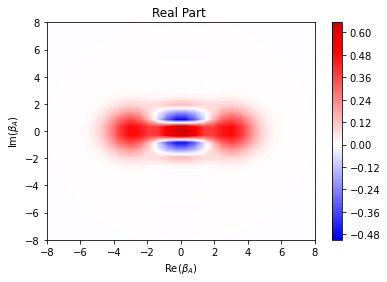

In [548]:
plt.contourf(x, y, Z, 200, cmap = 'seismic', norm = plt.Normalize(vmin = -1, vmax = 1))
plt.colorbar();      
plt.ylabel(r'Im($\beta_A$)')
plt.xlabel(r'Re($\beta_A$)')
plt.title('Real Part ')
plt.show()

In [549]:
Z = []
x = np.linspace(-8,8,30) #re part beta A 
y = np.linspace(-8,8,30) #im part beta A
ticker = 0
cstate = final3

for betaB in y:
    Z.append([])
    for betaA in x: 
        result = (cstate * cstate.dag()* displace(dim, betaA+ 1j*betaB)).tr()
        #defintion of characteristic function
        Z[ticker].append(result.imag)
    ticker += 1

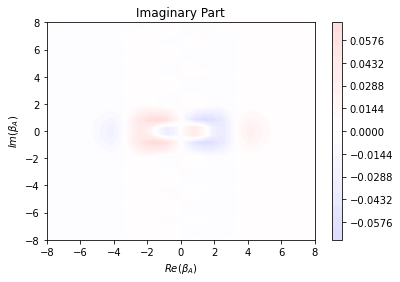

In [550]:
plt.contourf(x, y, Z, 200, cmap = 'seismic', norm = plt.Normalize(vmin = -1, vmax = 1))
plt.colorbar();      
plt.ylabel(r'$Im(\beta_A)$')
plt.xlabel(r'$Re(\beta_A)$')
plt.title('Imaginary Part')
plt.show()

In [18]:
np.rad2deg(0.04)

2.291831180523293